# Anomaly detection for clickstream data

## 0. Exploring data and date preparation

데이터 소스 : https://github.com/hortonworks/fieldeng-modern-clickstream

In [1]:
!gzip -d *.gz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### products dataset
- 16개의 타겟 페이지 (제품처럼 생각할 수 있을 듯)

In [91]:
products = pd.read_csv('products.tsv', header=None)
columns = pd.DataFrame(products[0].str.strip().str.split('\t').tolist()[0])
products = pd.DataFrame(products[0].str.strip().str.split('\t').tolist()[1:])
products.columns = columns
products

,"(url,)","(category,)","(id,)"
0,/,home page,1000
1,/video/1001,video review,1001
2,/video/1002,video review,1002
3,/video/1003,video review,1003
4,/reco/2001,celebirity recommendation,2001
5,/reco/2002,celebirity recommendation,2002
6,/review/3001,customer review,3001
7,/review/3002,customer review,3002
8,/review/3003,customer review,3003
9,/review/3004,customer review,3004


#### users dataset
- SWID는 사용자 세션 아이디임

In [142]:
users = pd.read_csv('users.tsv', delimiter='\t')
users

,SWID,BIRTH_DT,GENDER_CD
0,0001BDD9-EABF-4D0D-81BD-D9EABFCD0D7D,8-Apr-84,F
1,00071AA7-86D2-4EB9-871A-A786D27EB9BA,7-Feb-88,F
2,00071B7D-31AF-4D85-871B-7D31AFFD852E,22-Oct-64,F
3,0007967E-F188-4598-9C7C-E64390482CFB,1-Jun-66,M
4,000B90B2-92DC-4A7A-8B90-B292DC9A7A71,13-Jun-84,M
...,...,...,...
38450,FFF69D73-CE85-4BD6-B10F-9F9F25CD7A74,19-Apr-87,M
38451,FFF9E6CB-D3A2-455F-B5CF-6B8EC4E80ABE,21-Mar-53,U
38452,FFFB1C5E-37B6-453A-83FB-86C580D18AE8,24-Jan-90,M
38453,NaN,NaN,NaN


#### clickstreams 
- 이 데이터가 메인임

In [147]:
cs = pd.read_csv('clickstream-feed-generated.tsv', header=None, delimiter='|')
cs.columns = pd.read_csv('clickstream-data-schema.txt', delimiter='|').columns
cs['timestamp'] = cs['timestamp'].astype('datetime64')
cs.set_index('timestamp', inplace=True)
cs

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:19,1330588819,147.222.227.200,http://www.RL.com/,0,0.000000,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,spokane,wa,usa
2012-03-01 00:00:25,1330588825,99.49.96.163,http://www.RL.com/product/4004,0,1.000000,C9183A22-6E1D-4147-BDC9-D634FC957098,detroit,mi,usa
2012-03-01 00:00:27,1330588827,147.222.227.200,http://www.RL.com/,0,0.000000,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,spokane,wa,usa
2012-03-01 00:00:57,1330588857,69.114.3.205,http://www.RL.com/product/4004,0,0.000000,F761B842-9DDA-42CC-9F28-A6359B6C7219,east northport,ny,usa
2012-03-01 00:00:59,1330588859,71.217.29.209,http://www.RL.com/review/3004,0,0.595960,6FE1CB72-95C9-47F9-A1CB-7295C927F916,tacoma,wa,usa
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/product/4004,0,0.000000,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/reco/2001,0,0.414141,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:25,1331881165,50.39.205.175,http://www.RL.com/,0,0.000000,E3E83074-A1DF-4745-87BA-97E3C64ECA00,portland,or,usa


- 동일 시간에 클릭이벤트가 두 개 이상인 건들이 있네

In [148]:
cs.groupby('timestamp').count()

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-01 00:00:19,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:25,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:27,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:57,1,1,1,1,1,1,1,1,1
2012-03-01 00:00:59,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2012-03-15 23:58:16,1,1,1,1,1,1,1,1,1
2012-03-15 23:59:01,2,2,2,2,2,2,2,2,2
2012-03-15 23:59:25,1,1,1,1,1,1,1,1,1


- 한번 클릭으로 여러 사이트를 클릭하는 시나리오인 것으로 이해됨

In [149]:
cs.loc['2012-03-15 23:59:01']

,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state,country
timestamp,,,,,,,,,
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/product/4004,0,0.000000,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa
2012-03-15 23:59:01,1331881141,74.240.132.6,http://www.RL.com/reco/2001,0,0.414141,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,slidell,la,usa


- 컬럼값별 분포를 살펴보자
    + url : 16개의 타겟 페이지
    + is_purchased? : 모르겠음. 구매이력이 있다는 뜻일까?
    + is_page_errored? : 모르겠음.  에러가 날 확률인가?? 
    + user_session_id : 이걸로 사용자를 구별할 수 있음.
    + city, state, country : clickstream orign의 속성인가 봄

In [106]:
for column in cs.columns:
    if column not in ['clickstream_id','IP address','user_session_id']:
        display(cs.groupby(column).count())

,clickstream_id,IP address,is_purchased?,is_page_errored?,user_session_id,city,state,country
url,,,,,,,,
http://www.RL.com/,148594,148594,148594,148594,148594,148594,148594,148594
http://www.RL.com/product/4001,27085,27085,27085,27085,27085,27085,27085,27085
http://www.RL.com/product/4002,26898,26898,26898,26898,26898,26898,26898,26898
http://www.RL.com/product/4003,27227,27227,27227,27227,27227,27227,27227,27227
http://www.RL.com/product/4004,26854,26854,26854,26854,26854,26854,26854,26854
http://www.RL.com/product/4005,26968,26968,26968,26968,26968,26968,26968,26968
http://www.RL.com/reco/2001,13681,13681,13681,13681,13681,13681,13681,13681
http://www.RL.com/reco/2002,13911,13911,13911,13911,13911,13911,13911,13911
http://www.RL.com/review/3001,13875,13875,13875,13875,13875,13875,13875,13875


,clickstream_id,IP address,url,is_page_errored?,user_session_id,city,state,country
is_purchased?,,,,,,,,
0,404337,404337,404337,404337,404337,404337,404337,404337
1,16929,16929,16929,16929,16929,16929,16929,16929


,clickstream_id,IP address,url,is_purchased?,user_session_id,city,state,country
is_page_errored?,,,,,,,,
0.000000,279410,279410,279410,279410,279410,279410,279410,279410
0.010101,1398,1398,1398,1398,1398,1398,1398,1398
0.020202,1370,1370,1370,1370,1370,1370,1370,1370
0.030303,1407,1407,1407,1407,1407,1407,1407,1407
0.040404,1382,1382,1382,1382,1382,1382,1382,1382
...,...,...,...,...,...,...,...,...
0.959596,1364,1364,1364,1364,1364,1364,1364,1364
0.969697,1370,1370,1370,1370,1370,1370,1370,1370
0.979798,1423,1423,1423,1423,1423,1423,1423,1423


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,state,country
city,,,,,,,,
abbeville,15,15,15,15,15,15,15,15
aberdeen,73,73,73,73,73,73,73,73
abilene,416,416,416,416,416,416,416,416
abingdon,16,16,16,16,16,16,16,16
abington,17,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...,...
yuma,48,48,48,48,48,48,48,48
zanesville,64,64,64,64,64,64,64,64
zellwood,3,3,3,3,3,3,3,3


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,country
state,,,,,,,,
03,2,2,2,2,2,2,2,2
10,104,104,104,104,104,104,104,104
11,54,54,54,54,54,54,54,54
47,1,1,1,1,1,1,1,1
ab,68,68,68,68,68,68,68,68
...,...,...,...,...,...,...,...,...
wa,11138,11138,11138,11138,11138,11138,11138,11138
wi,8291,8291,8291,8291,8291,8291,8291,8291
wv,1977,1977,1977,1977,1977,1977,1977,1977


,clickstream_id,IP address,url,is_purchased?,is_page_errored?,user_session_id,city,state
country,,,,,,,,
aus,174,174,174,174,174,174,174,174
can,133,133,133,133,133,133,133,133
che,14,14,14,14,14,14,14,14
col,2,2,2,2,2,2,2,2
cze,50,50,50,50,50,50,50,50
deu,90,90,90,90,90,90,90,90
esp,8,8,8,8,8,8,8,8
fra,62,62,62,62,62,62,62,62
gbr,42,42,42,42,42,42,42,42


#### clickstream 데이터 가공

- 특정 시간 윈도우동안 어떤 페이지를 몇명이 클릭했는지가 분석 대상인 것으로 생각해보자. 

In [197]:
css = cs[['user_session_id', 'url', 'clickstream_id']].groupby(['url', 'timestamp','user_session_id']).count().reset_index()
css

,url,timestamp,user_session_id,clickstream_id
0,http://www.RL.com/,2012-03-01 00:00:19,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
1,http://www.RL.com/,2012-03-01 00:00:27,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
2,http://www.RL.com/,2012-03-01 00:01:21,AF8A0FDF-B1F8-474C-8CD7-8CA06A8E435B,1
3,http://www.RL.com/,2012-03-01 00:01:30,60C8049D-C1A2-41C2-B503-6C1200424C49,1
4,http://www.RL.com/,2012-03-01 00:01:45,F761B842-9DDA-42CC-9F28-A6359B6C7219,1
...,...,...,...,...
397936,http://www.RL.com/video/1003,2012-03-15 23:52:13,632959ED-DE61-43E4-A9BC-0F8E1AA6B070,1
397937,http://www.RL.com/video/1003,2012-03-15 23:52:26,A30C1420-DF86-DABF-50CA-F490E9338E95,1
397938,http://www.RL.com/video/1003,2012-03-15 23:53:34,A30C1420-DF86-DABF-50CA-F490E9338E95,1
397939,http://www.RL.com/video/1003,2012-03-15 23:54:30,3C9AB6C3-D275-4AA1-8BA3-CE401DBD1E98,1


- 동일 timestamp에 한 사용자 세션에서 동일 url을 여러번 클릭하는 경우도 있구나..

In [198]:
css[css['clickstream_id'] > 1]

,url,timestamp,user_session_id,clickstream_id
21,http://www.RL.com/,2012-03-01 00:07:28,40B1658D-9C3D-4745-A6B2-95F9B1D85CEB,2
26,http://www.RL.com/,2012-03-01 00:12:50,E1D2DE32-6F67-4A50-ABC1-102555658531,2
36,http://www.RL.com/,2012-03-01 00:17:20,6375FC70-8A3D-444A-B5FC-708A3DF44AF7,2
56,http://www.RL.com/,2012-03-01 00:27:57,88FC5287-907D-48FF-82A3-134F2EBC6351,2
58,http://www.RL.com/,2012-03-01 00:28:59,88FC5287-907D-48FF-82A3-134F2EBC6351,2
...,...,...,...,...
397822,http://www.RL.com/video/1003,2012-03-15 21:20:26,0A4EE364-0EE3-41B1-9DEC-086B7E50D2D6,2
397836,http://www.RL.com/video/1003,2012-03-15 21:33:47,374D69E0-AE27-4E91-B862-2BDCC6A5ED5E,2
397879,http://www.RL.com/video/1003,2012-03-15 22:18:34,EF1FF388-0622-434A-8DE7-7B01BC07DDF5,2
397888,http://www.RL.com/video/1003,2012-03-15 22:28:37,83B2A6CE-BBEC-44A1-ADA5-090FEC6EDCBE,2


- url별로 10분 단위로 사용자 세션수와 클릭수를 집계해보자
- deepar 알고리즘 포맷으로 가공한다. ({"start": "2014-01-01 00:00:00", "target": [2.6967005076142154, 2.8553299492385804, 2.53807106598985...)

In [199]:
# for p in products['url']:
#     print(p)
urls = css['url'].unique()
urls

array(['http://www.RL.com/', 'http://www.RL.com/product/4001',
       'http://www.RL.com/product/4002', 'http://www.RL.com/product/4003',
       'http://www.RL.com/product/4004', 'http://www.RL.com/product/4005',
       'http://www.RL.com/reco/2001', 'http://www.RL.com/reco/2002',
       'http://www.RL.com/review/3001', 'http://www.RL.com/review/3002',
       'http://www.RL.com/review/3003', 'http://www.RL.com/review/3004',
       'http://www.RL.com/review/3005', 'http://www.RL.com/video/1001',
       'http://www.RL.com/video/1002', 'http://www.RL.com/video/1003'],
      dtype=object)

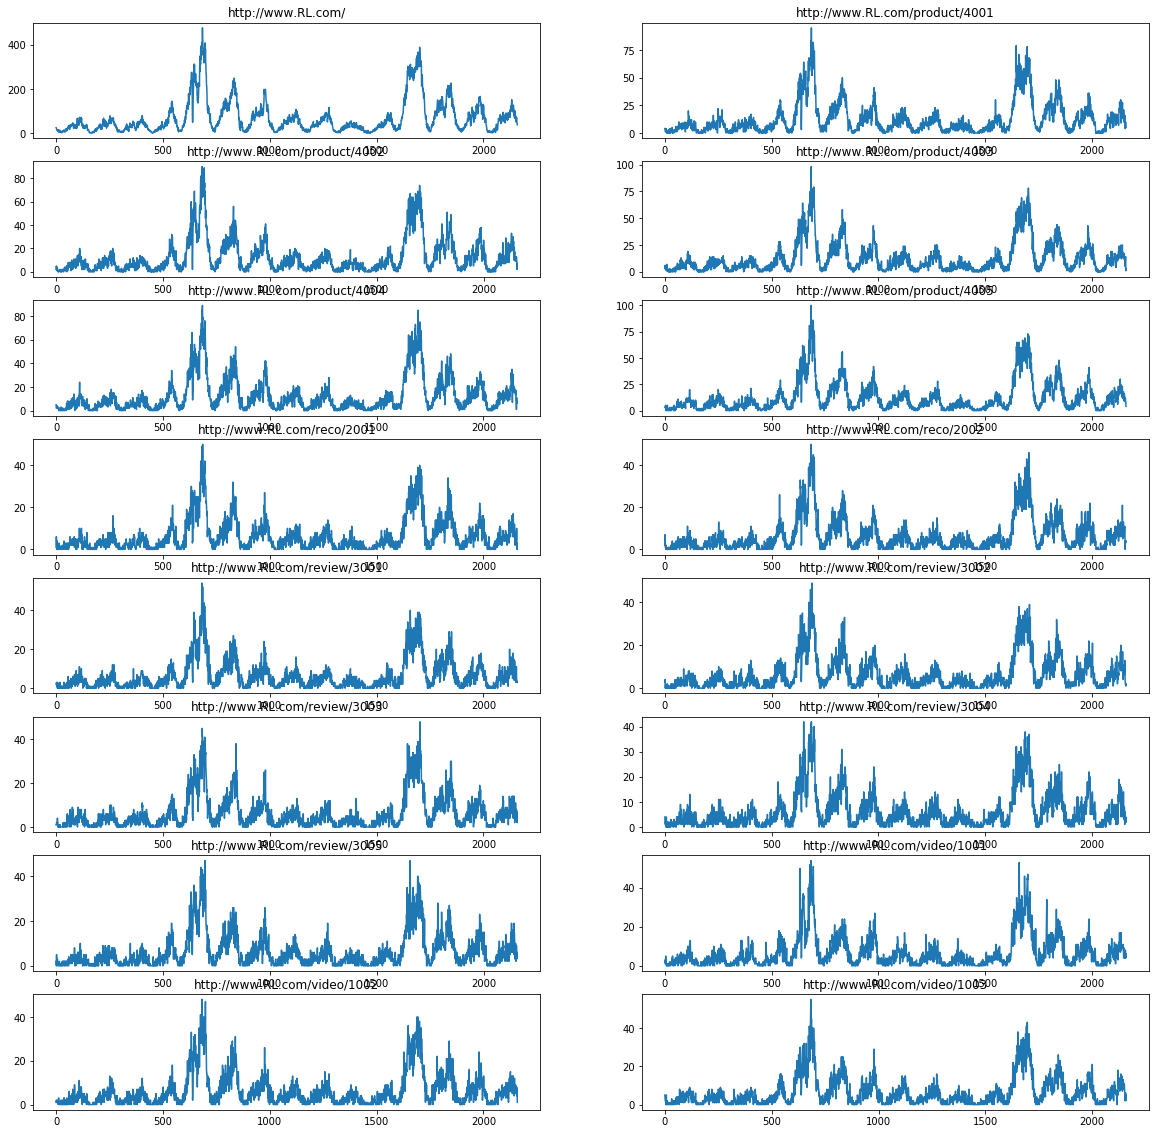

In [287]:
# css = css.groupby(['url','timestamp','user_session_id']).count().reset_index()
# # css.set_index(['url','timestamp']).resample('10T').nunique()
# urls = css.url.unique()
plt.figure(figsize=(20,20))
data = []
for index, url in zip(range(len(urls)), urls):
    r = css[css['url'] == url].set_index('timestamp').resample('10T')
    l = {'start' : str(s.index[0]),
         'target': list(r.sum()['clickstream_id'].values.astype('float')),
         'dynamic_feat': [list(r.nunique()['user_session_id'].values.astype('float'))]
        }
    data.append(l)
    
    # optional 
    plt.subplot(8,2, index+1)
    plt.plot(l['target'])
    plt.title(url)
    

In [266]:
print(data[0].keys())

dict_keys(['start', 'target', 'dynamic_feat'])


In [267]:
import json

def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))
            
write_dicts_to_file("train.json", data)

## 1. Kinesis Analytics를 이용한 실시간 이상감지

## 2. Cloud Watch AD를 이용한 모니터링

## 3. SageMaker Random Cut Forest 를 이용한 이상치 분석

## 4. 시계열 예측 기법을 이용한 이상치 분석

In [268]:
import sagemaker

sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-clickstream'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [269]:
train_s3 = sagemaker_session.upload_data(path='train.json', key_prefix=s3_prefix)
train_s3

's3://sagemaker-us-east-1-308961792850/deepar-clickstream/train.json'

In [270]:
import s3fs

s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(train_s3, 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2012-03-01 00:10:00", "target": [24.0, 22.0, 20.0, 17.0, 15.0, 12.0, 15.0, 10.0, 14.0, 9....


#### SageMaker DeepAR Tranining

In [271]:
import datetime 

region = sagemaker_session.boto_region_name

# we use 2 hour frequency for the time series
freq = datetime.timedelta(minutes=10)

# we predict for 24 hours
prediction_length = 24 * 6

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 24 * 6

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

In [272]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-clickstream'
)

In [273]:
hyperparameters = {
    "time_freq": '10min',
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}
estimator.set_hyperparameters(**hyperparameters)

In [274]:
%%time
data_channels = {
    "train": train_s3
}

estimator.fit(data_channels, wait=True)

2020-07-21 04:24:39 Starting - Starting the training job...
2020-07-21 04:24:41 Starting - Launching requested ML instances.........
2020-07-21 04:26:24 Starting - Preparing the instances for training......
2020-07-21 04:27:21 Downloading - Downloading input data
2020-07-21 04:27:21 Training - Downloading the training image..Arguments: train
[07/21/2020 04:27:52 INFO 139917391685440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/21/2020 04:27:5

In [347]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + datetime.timedelta(minutes=10)
#         prediction_time = 144
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
#         prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)       
#         print(prediction_time)
#         print(type(prediction_time))
#         print(prediction_length)
#         print(type(prediction_length))
#         print(freq)
#         print(type(freq))
        
        prediction_index = pd.date_range(prediction_time, prediction_time + freq * (prediction_length-1), freq=freq)
#         print(prediction_index)
        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [348]:
predictor.delete_endpoint()
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor, 
    wait=False)

In [345]:
infs = pd.Series(data[0]['target'][:-144])
infs.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2015), freq='10T')
infs

2012-03-01 00:10:00    24.0
2012-03-01 00:20:00    22.0
2012-03-01 00:30:00    20.0
2012-03-01 00:40:00    17.0
2012-03-01 00:50:00    15.0
                       ... 
2012-03-14 23:20:00    60.0
2012-03-14 23:30:00    60.0
2012-03-14 23:40:00    38.0
2012-03-14 23:50:00    36.0
2012-03-15 00:00:00    29.0
Freq: 10T, Length: 2016, dtype: float64

In [350]:
prediction = predictor.predict(ts= infs, 
                               dynamic_feat=data[0]['dynamic_feat'],
                               quantiles=[0.10, 0.5, 0.90])

In [365]:
infsf = pd.Series(data[0]['target'])
infsf.index=pd.date_range(data[0]['start'], datetime.datetime.strptime(data[0]['start'],  '%Y-%m-%d %H:%M:%S') + datetime.timedelta(minutes=10*2159), freq='10T')
infsf

2012-03-01 00:10:00    24.0
2012-03-01 00:20:00    22.0
2012-03-01 00:30:00    20.0
2012-03-01 00:40:00    17.0
2012-03-01 00:50:00    15.0
                       ... 
2012-03-15 23:20:00    68.0
2012-03-15 23:30:00    70.0
2012-03-15 23:40:00    50.0
2012-03-15 23:50:00    45.0
2012-03-16 00:00:00    37.0
Freq: 10T, Length: 2160, dtype: float64

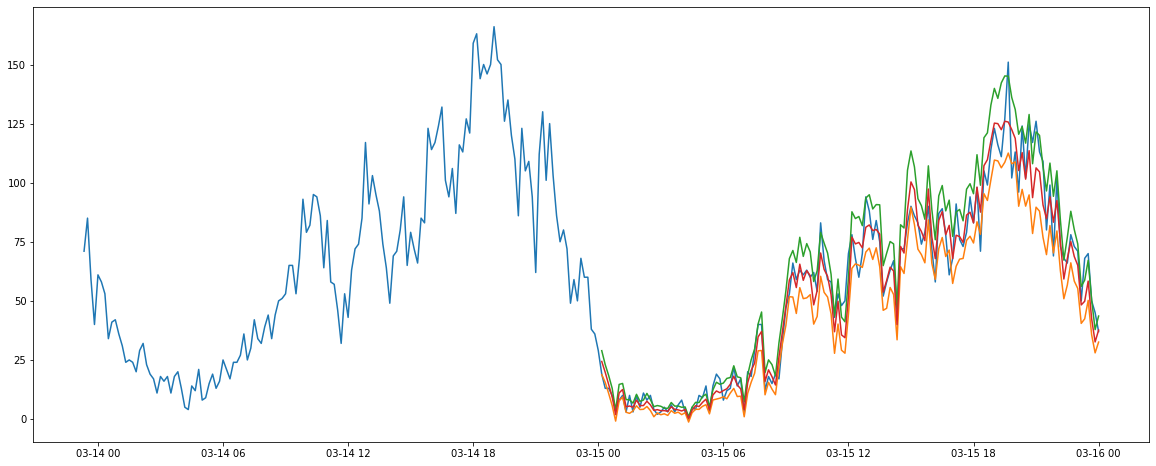

In [371]:
plt.figure(figsize=(20,8))
plt.plot(infsf['2012-03-13 23:20:00':])
plt.plot(prediction)
plt.show()